In [1]:
import molsysmt as msm
from molsysmt import pyunitwizard as puw
import omembrane as omem
import openmm as mm
from openmm import app as app
from openmm import unit as u
import numpy as np
import math
from matplotlib import pyplot as plt
from tqdm import tqdm
from sys import stdout

from openmm import LocalEnergyMinimizer

In [2]:
molsys = msm.convert('memb_popc_100_stage_2_4.h5msm')

In [3]:
P_atoms = msm.select(molsys, selection='atom_type=="P" and molecule_type=="lipid"')
N_atoms = msm.select(molsys, selection='atom_type=="N" and molecule_type=="lipid"')
O_atoms = msm.select(molsys, selection='atom_type=="O" and molecule_type=="lipid"')
C_atoms = msm.select(molsys, selection='atom_type=="C" and molecule_type=="lipid"')
OW_atoms = msm.select(molsys, selection='atom_type=="O" and molecule_type=="water"')

PO_heads_atoms = msm.select(molsys, selection='atom_name in ["P","O11","O12","O13","O14"] and molecule_type=="lipid"')

In [4]:
topology = msm.convert(molsys, 'openmm.topology')
positions = msm.get(molsys, coordinates=True)

In [5]:
forcefield = mm.app.ForceField("amber14-all.xml", "amber14/tip3p.xml")

In [6]:
system = forcefield.createSystem(topology, nonbondedMethod=app.PME, nonbondedCutoff=1.2*u.nanometer, constraints=app.HBonds)

In [7]:
friction = 1 / u.picosecond
timestep = 2 * u.femtoseconds
temperature = 0 * u.kelvin
integrator = mm.LangevinIntegrator(temperature, friction, timestep)

In [8]:
platform = mm.Platform.getPlatformByName("CUDA")

In [9]:
simulation = app.Simulation(topology, system, integrator, platform)
simulation.context.setPositions(msm.pyunitwizard.convert(positions[0], to_form='openmm.unit'))

In [10]:
msm.thirds.openmm.forces.harmonic_potential_to_coordinates(simulation.context, selection=PO_heads_atoms,
                                                          force_constant=5000.0*u.kilojoules_per_mole/(u.nanometer**2),
                                                          pbc=True, adding_force=True)

5

In [11]:
simulation.minimizeEnergy()

In [12]:
state_init = simulation.context.getState(getPositions=True, enforcePeriodicBox=True)

In [13]:
reporter = app.StateDataReporter(stdout, 10000, step=True, potentialEnergy=True, temperature=True)
simulation.reporters = [reporter]

In [14]:
simulation.integrator.setTemperature(50*u.kelvin)
simulation.step(50000) # 100 ps
simulation.integrator.setTemperature(100*u.kelvin)
simulation.step(50000) # 100 ps
simulation.integrator.setTemperature(150*u.kelvin)
simulation.step(50000) # 100 ps
simulation.integrator.setTemperature(200*u.kelvin)
simulation.step(50000) # 100 ps
simulation.integrator.setTemperature(250*u.kelvin)
simulation.step(50000) # 100 ps
simulation.integrator.setTemperature(300*u.kelvin)
simulation.step(50000) # 100 ps

#"Step","Potential Energy (kJ/mole)","Temperature (K)"
10000,-824320.7158092638,50.50074798772973
20000,-826849.2236217638,49.88147278647296
30000,-828669.5146373888,50.1068156704514
40000,-829274.8193248888,49.705609302630755
50000,-829917.1005748888,49.949262185988275
60000,-800234.6220592638,99.44325183651165
70000,-803045.6747936388,100.04210387787315
80000,-805249.8661998888,100.73521153904098
90000,-806328.5790905138,100.1905274717695
100000,-807071.3427623888,99.56099239934979
110000,-774554.1454967638,150.1846928716828
120000,-777277.3290905138,150.65905694575497
130000,-780315.9267467638,148.32730879517035
140000,-781120.1220592638,149.54374284178118
150000,-782051.7431530138,150.01750719908702
160000,-740935.7607311388,201.90048260273554
170000,-743312.1298717638,200.11452305554096
180000,-746560.1747936388,200.26319190366357
190000,-748038.4775280138,199.74255161584597
200000,-748952.3818248888,201.70487574193695
210000,-695302.1669811388,250.48579131299093
220000,-695636.82

In [15]:
state_end = simulation.context.getState(getPositions=True, enforcePeriodicBox=True)

/fast_data/home/diego/miniconda3/envs/OMembrane@uibcdf_3.11/lib/python3.11/site-packages/matplotlib/cbook.py:1345: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


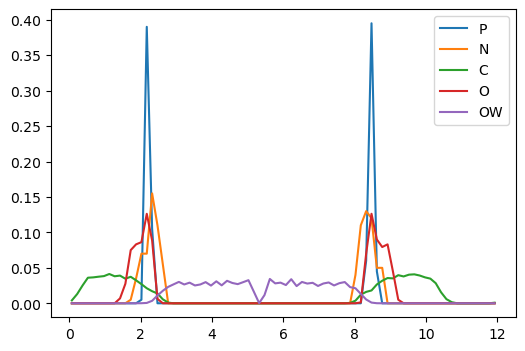

In [16]:
bins_edges_P_init, density_P_init = omem.analysis.get_lineal_density(state_init, selection = P_atoms, axis = [0,0,1],
                                                       bins = 80, range="[0.0, 12.0] nm", normalized=True)
bins_edges_N_init, density_N_init = omem.analysis.get_lineal_density(state_init, selection = N_atoms, axis = [0,0,1],
                                                       bins = 80, range="[0.0, 12.0] nm", normalized=True)
bins_edges_C_init, density_C_init = omem.analysis.get_lineal_density(state_init, selection = C_atoms, axis = [0,0,1],
                                                       bins = 80, range="[0.0, 12.0] nm", normalized=True)
bins_edges_O_init, density_O_init = omem.analysis.get_lineal_density(state_init, selection = O_atoms, axis = [0,0,1],
                                                       bins = 80, range="[0.0, 12.0] nm", normalized=True)
bins_edges_OW_init, density_OW_init = omem.analysis.get_lineal_density(state_init, selection=OW_atoms, axis = [0,0,1],
                                                       bins = 80, range="[0.0, 12.0] nm", normalized=True)


plt.rcParams["figure.figsize"] = (6,4)
plt.plot((bins_edges_P_init[1:]+bins_edges_P_init[:-1])/2, density_P_init, label='P')
plt.plot((bins_edges_N_init[1:]+bins_edges_N_init[:-1])/2, density_N_init, label='N')
plt.plot((bins_edges_C_init[1:]+bins_edges_C_init[:-1])/2, density_C_init, label='C')
plt.plot((bins_edges_O_init[1:]+bins_edges_O_init[:-1])/2, density_O_init, label='O')
plt.plot((bins_edges_OW_init[1:]+bins_edges_OW_init[:-1])/2, density_OW_init, label='OW')
plt.legend()

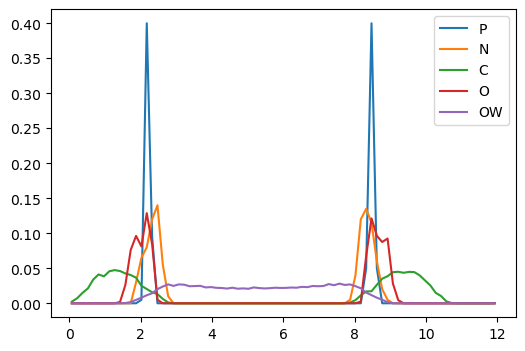

In [17]:
bins_edges_P_end, density_P_end = omem.analysis.get_lineal_density(state_end, selection = P_atoms, axis = [0,0,1],
                                                       bins = 80, range="[0.0, 12.0] nm", normalized=True)
bins_edges_N_end, density_N_end = omem.analysis.get_lineal_density(state_end, selection = N_atoms, axis = [0,0,1],
                                                       bins = 80, range="[0.0, 12.0] nm", normalized=True)
bins_edges_C_end, density_C_end = omem.analysis.get_lineal_density(state_end, selection = C_atoms, axis = [0,0,1],
                                                       bins = 80, range="[0.0, 12.0] nm", normalized=True)
bins_edges_O_end, density_O_end = omem.analysis.get_lineal_density(state_end, selection = O_atoms, axis = [0,0,1],
                                                       bins = 80, range="[0.0, 12.0] nm", normalized=True)
bins_edges_OW_end, density_OW_end = omem.analysis.get_lineal_density(state_end, selection=OW_atoms, axis = [0,0,1],
                                                       bins = 80, range="[0.0, 12.0] nm", normalized=True)

plt.rcParams["figure.figsize"] = (6,4)
plt.plot((bins_edges_P_end[1:]+bins_edges_P_end[:-1])/2, density_P_end, label='P')
plt.plot((bins_edges_N_end[1:]+bins_edges_N_end[:-1])/2, density_N_end, label='N')
plt.plot((bins_edges_C_end[1:]+bins_edges_C_end[:-1])/2, density_C_end, label='C')
plt.plot((bins_edges_O_end[1:]+bins_edges_O_end[:-1])/2, density_O_end, label='O')
plt.plot((bins_edges_OW_end[1:]+bins_edges_OW_end[:-1])/2, density_OW_end, label='OW')
plt.legend()
plt.show()

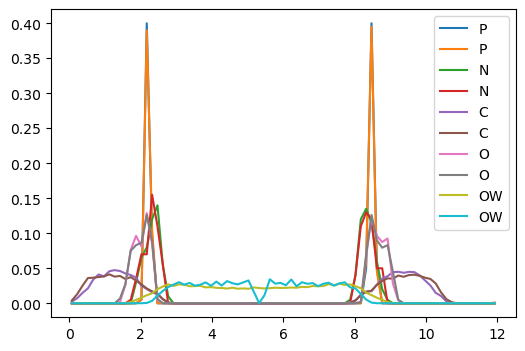

In [19]:
plt.rcParams["figure.figsize"] = (6,4)
plt.plot((bins_edges_P_end[1:]+bins_edges_P_end[:-1])/2, density_P_end, label='P')
plt.plot((bins_edges_P_init[1:]+bins_edges_P_init[:-1])/2, density_P_init, label='P')

plt.plot((bins_edges_N_end[1:]+bins_edges_N_end[:-1])/2, density_N_end, label='N')
plt.plot((bins_edges_N_init[1:]+bins_edges_N_init[:-1])/2, density_N_init, label='N')

plt.plot((bins_edges_C_end[1:]+bins_edges_C_end[:-1])/2, density_C_end, label='C')
plt.plot((bins_edges_C_init[1:]+bins_edges_C_init[:-1])/2, density_C_init, label='C')

plt.plot((bins_edges_O_end[1:]+bins_edges_O_end[:-1])/2, density_O_end, label='O')
plt.plot((bins_edges_O_init[1:]+bins_edges_O_init[:-1])/2, density_O_init, label='O')

plt.plot((bins_edges_OW_end[1:]+bins_edges_OW_end[:-1])/2, density_OW_end, label='OW')
plt.plot((bins_edges_OW_init[1:]+bins_edges_OW_init[:-1])/2, density_OW_init, label='OW')

plt.legend()
plt.show()

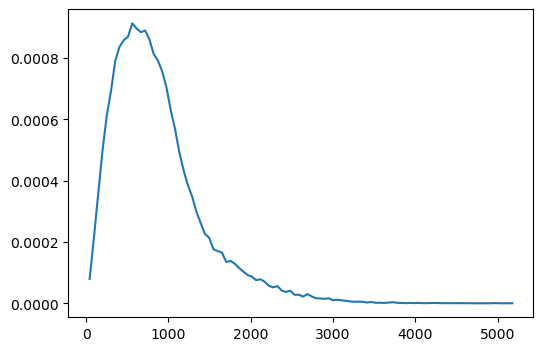

In [20]:
forces = msm.molecular_mechanics.get_forces(simulation.context, norm=True)
h, bins = np.histogram(puw.get_value(forces), bins=100, density=True)
plt.plot(0.5*(bins[1:]+bins[:-1]), h)
plt.show()

In [21]:
#memb_antes = msm.extract(molsys, selection='molecule_type=="lipid"', to_form='molsysmt.MolSys')
#memb_despues = msm.extract([molsys, simulation.context], selection='molecule_type=="lipid"', to_form='molsysmt.MolSys')

In [22]:
#msm.view(memb_despues)

In [23]:
coordinates = msm.get(state_end, coordinates=True)
msm.set(molsys, coordinates=coordinates)

In [24]:
msm.view(molsys, standard=False)

NGLWidget()

In [25]:
msm.convert(molsys, 'memb_popc_100_stage_3_0.h5msm')

'memb_popc_100_stage_3_0.h5msm'